<a href="https://www.kaggle.com/code/galvangoh/ai200-lc-loan-default-prediction?scriptVersionId=101494651" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

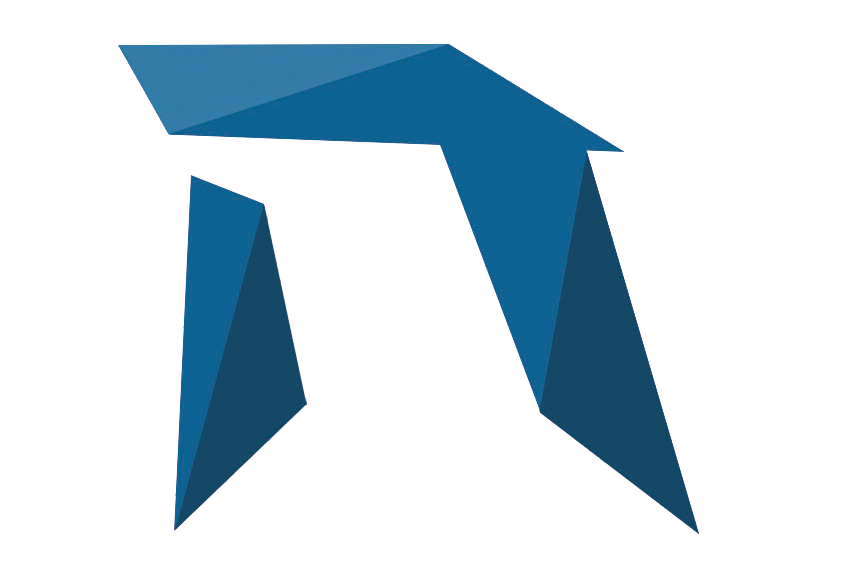

***
# HEICODERS ACADEMY
<b>AI200: Applied Machine Learning</b><br>
***
<b>Capstone Project:</b> Loan Default Prediction Competition [Student Notebook]
***

Before we start, we will import all the libraries needed for this Student Notebook.

In [ ]:
# for working with dataframes
import pandas as pd

# to perform mathematical operations
import numpy as np

# for visualisation
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go

# for feature engineering
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from sklearn.preprocessing import StandardScaler

# for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# working with various machine model selected for this project
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

# for evaluating predictions
from sklearn import metrics
import statistics
from sklearn.metrics import roc_curve, auc

# to hide warnings from output
import warnings
warnings.filterwarnings("ignore")

# to display multiple outputs within the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 1.📝Data Preparation (Part 1)
---

> **OVERALL GOAL:** 
> - Ingest the data and relabelling the outcome variable

## 1a. Import Dataset

We import the dataset using <code>read_csv()</code>

In [ ]:
train_df = pd.read_csv("../input/lendingclub-loan-default-prediction/lc_trainingset.csv")
test_df = pd.read_csv("../input/lendingclub-loan-default-prediction/lc_trainingset.csv")

train_df

## 1b. How many rows/columns in each dataset?

We understand the dimensionality of the data using <code>.shape</code>

In [ ]:
print(train_df.shape)
print(test_df.shape)

<div class="alert alert-block alert-warning">
Observe that you are have only 26 columns in the <code>test_df</code>, and that is the outcome variable which you are supposed to generate predictions for and submit to Kaggle.</div>

## 1c. Check Out Loan Status

We use <code>value_counts()</code> to see the number of instances of each unique status in the loan_status data column

In [ ]:
train_df['loan_status'].value_counts()

We visualise the loan status for ease of interpretation

In [ ]:
import plotly.express as px

fig = px.bar(train_df['loan_status'].value_counts(), width=800, height=500)
fig.show()

<div class="alert alert-block alert-warning">
While our descriptive analysis shows that the outcome variable only has 2 different outcomes, according to the business rules, it is possible that the column that we are trying to predict for has other different outcomes. As a good data scientist, we need to deal with this possibility so that if a data with a new outcome occurs the model will be able to deal with it accordingly. So how do we go about this?</div>

## 1d. Relabelling the Loan Status

From the above visualisation, we observed that around 10 type of loan status exist in this data set. We are only interested in 2 status i.e. <b>Defaulted</b> and <b>Not Defaulted</b>. Hence, we will need to add a new variable which will be binary (0s and 1s).

- 0 means Not Defaulted
- 1 means Defaulted

All those loans, whose status is “Fully Paid”, “Current” will be categorized as Not Defaulted and anything else will be categorized as Defaulted. To achieve this we will introduce new variable defaulted.

In [ ]:
# First we define the function
def change_loan_status(loan_status):
    if loan_status in ['Fully Paid', 'Current']:
        return 0
    else:
        return 1

# Next we apply the function
train_df['loan_status'] = train_df['loan_status'].apply(change_loan_status)
train_df.head()

Once again, we apply the <code>value_counts()</code> to see the number of instances of each unique status in the loan_status data column. Now we can see that the loan status only has 2 category.

In [ ]:
train_df['loan_status'].value_counts()

<div class="alert alert-block alert-warning">
So in the real world, when your column to be predicted has more than 2 outcomes, and you wish you classify them into 2 different outcomes, the above is one of the approach you can take - using logic/domain-knowledge to categorise the classes together.</div>

In [ ]:
# Perform data cleaning. You may create as many cells as you need

## 1e. Heatmap correlation
- Generate a heatmap to identify strong and weak correlation against the outcome.

In [ ]:
# create a new data frame to contain the correlation values of train data set.
corr_train_df = train_df.corr()

# Create a heat map of all the numerical features.
fig = px.imshow(corr_train_df, width=900, height=800,
                title='Heatmap Correlation for Train Data Set')
fig.show()

- Surprising to see that none of the numerical features have outstanding strong correlation with the outcome (loan_status).
- int_rate has the highest positive correlation value of 0.248.
- mort_acc has the highest negative correlation value of -0.074.
- Hope to observe improvement after data wrangling and feature engineering phase.
- We do however see strong correlation between certain features.
- loan_amnt & installment -> 0.953.
- pub_rec_bankruptcies & pub_rec -> 0.721.
- total_acc & open_acc -> 0.680.

## 1f. High level look at train_df and test_df

#### train data set

In [ ]:
train_df.describe().T

In [ ]:
train_df.info()

In [ ]:
train_df.head(3)

#### test data set

In [ ]:
test_df.describe().T

In [ ]:
test_df.info()

In [ ]:
test_df.head(3)

- From the results of test_df.info(), we can observe the similar dtypes discrepncies as seen in train_df.
- We will iterate the process of changing the dtypes for test_df (also column names at the same time).
- Null values will also iterate the similar process as done for train_df.
- Reminder that the imputation values for the test data set shall be using the imputation values initially computed at train data set.
- Reminder to not drop any of the rows for test data set.
- Also, for test_df id column, we can observe it is being recorded as an int (0,1,2...) instead of object (T1, T2, T3...) as seen in train_df. Since the id columns follows to the data frame index and id is not a critical feature, it can be ignored during the data wrangling process.

## 1g. Null values inspection for train_df and test_df
- Using .isnull( ) and and the missingno library to look at the amount of null values in both train and test data set.
- These null values will be handled later on.

In [ ]:
train_df.isnull().sum()

Features with null values in train_df:
1. emp_title
2. emp_length
3. title
4. revol_util
5. mort_acc
6. pub_rec_bankruptcies

Conclusion: 6 features with null values in train_df

In [ ]:
test_df.isnull().sum()

Features with null values in test_df:
1. emp_title
2. emp_length
3. title
4. mort_acc

Conclusion: 4 features with null values in test_df

#### using the missingno library to visualise the amount of null values.

In [ ]:
# msno.bar(train_df)
msno.matrix(train_df)

In [ ]:
msno.matrix(test_df)

While test_df has lesser features with null values, the proportion of null values it contains within the respective columns seems comparable to train_df

- Fortunately with only 27 columns in train_df, we can check the dtypes of the features individually.
- Some features dtypes can be converted from object to numeric and datetime.
- We will explore them in the next section.

## 1h. Correcting data types for train_df and test_df

- term = object dtype now, can be converted to numeric and change feature title
- emp_length = object dtype now, can be converted numeric and change feaure title
- issue_d, earliest_cr_line = object dtype now, can be converted to datetime

### 1h.1.1 train_df | term -> term_months
> string to numeric

In [ ]:
train_df.rename(columns = {'term':'term_months'}, inplace = True) # changing feature column name
train_df['term_months'] = train_df['term_months'].replace(' months', '', regex=True) # remove the word months
train_df['term_months'] = train_df['term_months'].apply(pd.to_numeric) # change dtype to numeric
print(train_df.term_months.dtypes)

### 1h.1.2 test_df | term -> term_months
> string to numeric

In [ ]:
test_df.rename(columns = {'term':'term_months'}, inplace = True) # changing feature column name
test_df['term_months'] = test_df['term_months'].replace(' months', '', regex=True) # remove the word months
test_df['term_months'] = test_df['term_months'].apply(pd.to_numeric) # change dtype to numeric
print(test_df.term_months.dtypes)

### 1h.2.1 train_df | emp_length -> emp_length_years
> string to numeric

In [ ]:
train_df.rename(columns = {'emp_length':'emp_length_years'}, inplace = True) # changing feature column name

# mapping all data within emp_length_years
train_df['emp_length_years'] = train_df['emp_length_years'].map({'10+ years':'10',
                                                                   '7 years':'7',
                                                                   '9 years':'9',
                                                                   '5 years':'5',
                                                                   '1 year':'1',
                                                                   '2 years':'2',
                                                                   '3 years':'3',
                                                                   '6 years':'6',
                                                                   '4 years':'4',
                                                                   '8 years':'8',
                                                                   '< 1 year':'0'})

train_df['emp_length_years'] = train_df['emp_length_years'].apply(pd.to_numeric) # change dtype to numeric
print(train_df.emp_length_years.dtypes)

### 1h.2.2 test_df | emp_length -> emp_length_years
> string to numeric

In [ ]:
test_df.rename(columns = {'emp_length':'emp_length_years'}, inplace = True) # changing feature column name

# mapping all data within emp_length_years
test_df['emp_length_years'] = test_df['emp_length_years'].map({'10+ years':'10',
                                                                   '7 years':'7',
                                                                   '9 years':'9',
                                                                   '5 years':'5',
                                                                   '1 year':'1',
                                                                   '2 years':'2',
                                                                   '3 years':'3',
                                                                   '6 years':'6',
                                                                   '4 years':'4',
                                                                   '8 years':'8',
                                                                   '< 1 year':'0'})

test_df['emp_length_years'] = test_df['emp_length_years'].apply(pd.to_numeric) # change dtype to numeric
print(train_df.emp_length_years.dtypes)

### 1h.3.1 train_df | issue_d & earliest_cr_line
- From below, you can see that the code which adds the date "01" being deliberately separated out.
- This is to avoid continuously adding another "01" to the dates when the next few lines of codes were to run more than once.
- The date as first day of the month is added into the data for the sole purpose for conversion of data type from object to datetime format and does not reflect the actual date to which the loan and credit line were made available to loan applicants.

In [ ]:
# adding a date into the column
train_df[['issue_d','earliest_cr_line']] = '01-' + train_df[['issue_d','earliest_cr_line']].astype(str)

In [ ]:
# using .apply to change the date format
train_df[['issue_d','earliest_cr_line']].apply(pd.to_datetime)

# changing object dtype to datetime dtype
# not sure why code does not work for line 7 in this cell
# train_df[['issue_d','earliest_cr_line']] = pd.to_datetime(train_df[['issue_d','earliest_cr_line']])
# a for loop function can be written if there are a considerable number of columns
train_df['issue_d'] = pd.to_datetime(train_df['issue_d'])
train_df['earliest_cr_line'] = pd.to_datetime(train_df['earliest_cr_line'])

# show the changed dtype
train_df[['issue_d','earliest_cr_line']].dtypes

### 1h.3.2 test_df | issue_d & earliest_cr_line

In [ ]:
# adding a date into the column
test_df[['issue_d','earliest_cr_line']] = '01-' + test_df[['issue_d','earliest_cr_line']].astype(str)

In [ ]:
# using .apply to change the date format
test_df[['issue_d','earliest_cr_line']].apply(pd.to_datetime)

# changing object dtype to datetime dtype
# a for loop function can be written if there are a considerable number of columns
test_df['issue_d'] = pd.to_datetime(test_df['issue_d'])
test_df['earliest_cr_line'] = pd.to_datetime(test_df['earliest_cr_line'])

# show the changed dtype
test_df[['issue_d','earliest_cr_line']].dtypes

### 1h.4 2nd correlation eatmap for train_df
- After changing some string feature to numeric feature, we do another heatmap to see how the new numeric features looks like against the outcome (loan_status).

In [ ]:
# create a new data frame to contain the correlation values of train data set.
corr_train_df = train_df.corr()

# Create a heat map of all the numerical features.
fig = px.imshow(corr_train_df, width=900, height=800,
                title='2nd Heatmap Correlation for Train Data Set')
fig.show()

- term_months seems to gives us one of the better correlation values however not as good as int_rate.
- emp_length_years gives us a negatively correlated value.

## 1i. Dealing with null values for train_df and test_df

Let's try using statistical methods together with plots to determine a good imputation method.<br>

<b>train_df</b>
1. emp_title - The job title supplied by the Borrower when applying for the loan.
2. emp_length_years - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
3. title - The loan title provided by the borrower.
4. revol_util - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
5. mort_acc - Number of mortgage accounts.
6. pub_rec_bankruptcies - Number of public record bankruptcies.

<b>test_df</b>
- From section 1e, we have concluded that there are 4 features in test_df are having null values.
- These 4 features are also found in train_df. So, we can use the same method where we clean the data in train_df on test_df.
- emp_title, emp_length, title, mort_acc

### traIn_df | emp_title
- There are 18310 null values in this column, we will not use .mode( ) as this will increase the number of teachers by a lot. It will tip the scale for this feature.
- To encourage randomness, we will fill the null values randomly using values within emp_tile. To do this we use a UDF.<br>
source: https://stackoverflow.com/questions/64485812/how-to-generate-random-categorical-data-from-existing-ones-to-fill-missing-value

In [ ]:
# look at top 10 title of applicants who took up loan and default
top10_defaulted_applicant = train_df[train_df.loan_status == 1].groupby(by='emp_title').sum().sort_values('loan_status', ascending=False)
top10_defaulted_applicant[['loan_status']].head(10)

In [ ]:
def na_randomfill(series):
    na_mask = pd.isnull(series)   # boolean mask for null values
    n_null = na_mask.sum()        # number of nulls in the Series
    
    if n_null == 0:
        return series             # if there are no nulls, no need to resample
    
    # Randomly sample the non-null values from our series
    # only sample this Series as many times as we have nulls 
    fill_values = series[~na_mask].sample(n=n_null, replace=True, random_state=0)

    # This ensures our new values will replace NaNs in the correct locations
    fill_values.index = series.index[na_mask]
    
    return series.fillna(fill_values) 

In [ ]:
# apply udf to emp_title
train_df['emp_title'] = na_randomfill(train_df['emp_title'])

# check the dtype is unchange
train_df.emp_title.dtypes

In [ ]:
train_df.emp_title.isnull().sum()

In [ ]:
top10_defaulted_applicant = train_df[train_df.loan_status == 1].groupby(by='emp_title').sum().sort_values('loan_status', ascending=False)
top10_defaulted_applicant[['loan_status']].head(10)

The udf works, we can observe that for each emp_title there is an increment in count.

### test_df | emp_title

In [ ]:
# see number of titles before cleaning
test_df['emp_title'].value_counts()

In [ ]:
# apply udf to emp_title
test_df['emp_title'] = na_randomfill(test_df['emp_title'])

# see numbner of titles after cleaning
test_df['emp_title'].value_counts()
test_df.emp_title.isnull().sum()
test_df.emp_title.dtypes

- From the above, it can be seen that titles such as Teacher, Manager, Registered Nurse, etc. has its count increase slightly.
- Titles such as senior system Engineer, assistant office manger still has its count remain as it is. They were not randomly picked and sampled for replacing NaN values.

### train_df | emp_length_years
- There are 14662 null values.
- Using the mean of employment years will not be ideal as the distibution is negative skewed.
- Using mean will create an additional group of employment years which will probably give something like 3.2 years.
- It is due to this, we will use the median of employment years to fill up the null values within emp_length_years.

In [ ]:
label_to_change = {'emp_length_years':'Years of Employment',
                   'loan_amnt':'Loan Amount',
                   'loan_status':'Loan Status'}

fig = px.histogram(train_df, x='emp_length_years', y='loan_amnt',
                   color='loan_status',
                   marginal='box',
                   title='Distribution of Loan Amount Based on Years of Employment',
                   labels=label_to_change
                   )

fig.update_yaxes(tickprefix="$")

- LendingClub best customers are applicants with 10 or more years of employment.
- This make sense as the larger the year goes, the older the applicant. Someone of age ought to possess more assets which require loans.

In [ ]:
# see the sum of loan applicant w.r.t employment years
train_df.emp_length_years.value_counts()

In [ ]:
# finding the mediam of employment years
train_df[['emp_length_years']].median()

In [ ]:
# fill up null values with the median
train_df['emp_length_years'] = train_df['emp_length_years'].fillna(train_df['emp_length_years'].median())

In [ ]:
train_df.emp_length_years.value_counts()
train_df.emp_length_years.isnull().sum()
train_df.emp_length_years.dtypes

- The amount of loan applicant with 6 years of employment has went up nearly 2 fold, but not a significant icrease in terms of its scale.

### test_df | emp_length_years

In [ ]:
# see the sum of loan applicant w.r.t employment years before cleaning
test_df.emp_length_years.value_counts()

In [ ]:
# fill up null values with the median computed from train_df
test_df['emp_length_years'] = test_df['emp_length_years'].fillna(train_df['emp_length_years'].median())

# see the sum of loan applicant w.r.t employment years after cleaning
test_df.emp_length_years.value_counts()
test_df.emp_length_years.isnull().sum()
test_df.emp_length_years.dtypes

### train_df | title
- There are 1401 null values within title.
- Since there are not much rows (~0.4% of train_df), it is safe to drop them away

In [ ]:
# see the sum of loan amount for all null-ed loan title
train_df[train_df['title'].isnull()].sum()[['loan_amnt']]

In [ ]:
# observe top 10 most popular loan in train data set
train_df.groupby('title').sum()[['loan_amnt']].sort_values(by='loan_amnt', ascending=False).head(10)

In [ ]:
# drop away rows with null values in title column
train_df.dropna(subset=['title'], inplace=True)

# check for null value in title column
train_df.title.isnull().sum()

# check rows remaining in train_df
train_df.shape

- Debt consolidation type of loan is the most popular as it has the greatest amount of loan.
- It can be found across several rows due to the nature of how the data set is populated.
- Reading up on debt consolidation - banks offer low interest rate to applicant which probably caught the attention of the applicant. It also offers a one-stop location to pay off loans which are scattered around (takes off the mental burden of applicant I guess).<br>
- source: https://www.moneysmart.sg/debt-consolidation-plan

### test_df | title
- For null values of title within test_df, we cannot drop away the null values. This will not meet the requirement of the competition.

In [ ]:
# see the sum of loan amount for all null-ed loan title
test_df[test_df['title'].isnull()].sum()[['loan_amnt']]

In [ ]:
# observe top 10 most popular loan
test_df.groupby('title').sum()[['loan_amnt']].sort_values(by='loan_amnt', ascending=False).head(10)

In [ ]:
# counter check with .mode()
test_df.title.mode()
train_df.title.mode()

- Similar to train_df, debt consolidation is the most popular type of loan.

In [ ]:
# fill null values with the most frequent value
test_df['title'] = test_df['title'].fillna(train_df['title'].mode()[0])

# check for null value in title column
test_df.title.isnull().sum()

# check rows is still the same
test_df.shape

### train_df | mort_acc
- There are 30203 null values.
- This is nearly 10% of train_df. It may not be beneficial during model training if we are to drop these null values.
- Using the median value of mort_acc to fill up the NaN values.

In [ ]:
label_to_change = {'mort_acc':'No. Mortgage Accounts',
                   'loan_amnt':'Loan Amount',
                   'loan_status':'Loan Status'}

fig = px.histogram(train_df, x='mort_acc', y='loan_amnt',
                   color='loan_status',
                   marginal='box',
                   title='Distribution of Loan Amount Based on No. of Mortgage Accounts',
                   labels=label_to_change
                   )

fig.update_yaxes(tickprefix="$")

In [ ]:
# finding the mediam of mort_acc
train_df.mort_acc.median()

In [ ]:
# fill up null values with the median
train_df['mort_acc'] = train_df['mort_acc'].fillna(train_df['mort_acc'].median())

# checking for null values. should be 0.
train_df.emp_length_years.isnull().sum()

### test_df | mort_acc
- Using median value computed from train_df and fill the null values in test_df.

In [ ]:
# fill up null values with the median
test_df['mort_acc'] = test_df['mort_acc'].fillna(train_df['mort_acc'].median())

# checking for null values. should be 0.
train_df.emp_length_years.isnull().sum()

### train_df | revol_util
- There are 225 null values.
- "While revolving credit utilization (it goes up and down) is fairly normal, it is important to always keep it below 30% if possible."<br>
source: https://www.investopedia.com/terms/c/credit-utilization-rate.asp
- This rate (%) can be calculated by summing up all credit used and divide by total available credit across all credit lines the borrower is holding.
- These information is not available in the data set. So we will drop these null values.
- This feature has no null value for test data set.

In [ ]:
# drop away rows with null values in revol_util column
train_df.dropna(subset=['revol_util'], inplace=True)

# check for null value in title column
train_df.revol_util.isnull().sum()

# check rows remaining in train_df
train_df.shape

### train_df | pub_rec_bankruptcies
- There are 436 null values.
- It seems that using .mode( ) to fill up null values will not significantly affect the distribution of this feature.

In [ ]:
label_to_change = {'pub_rec_bankruptcies':'No. of Public Record Bankruptcies',
                   'loan_amnt':'Loan Amount',
                   'loan_status':'Loan Status',
                   'term_months':'Loan Repayment Term'}

fig = px.box(train_df,
             x="pub_rec_bankruptcies", y="loan_amnt",
             color='loan_status',
             facet_row='term_months',
             labels=label_to_change,
             title='Distribution of Public Record Bankruptcies Between 36 & 60 Months Repayment Term'
             )

fig.update_yaxes(tickprefix="$")

In [ ]:
train_df.groupby('loan_status').sum()[['pub_rec_bankruptcies']]

In [ ]:
# find the most number of public record bankruptcies
train_df['pub_rec_bankruptcies'].mode()[0]

In [ ]:
# look at how much default are there based the number of bankruptcies
train_df[['pub_rec_bankruptcies','loan_status']].value_counts()

In [ ]:
# replace null values with .mode()
train_df['pub_rec_bankruptcies'] = train_df['pub_rec_bankruptcies'].fillna(train_df['pub_rec_bankruptcies'].mode()[0])

# check for null value in pub_rec_bankruptcies column
train_df.pub_rec_bankruptcies.isnull().sum()

### Ensuring train_df and test_df are both cleaned

In [ ]:
train_df.isnull().sum()
test_df.isnull().sum()
train_df.shape
test_df.shape

# 2.🔍Exploratory Data Analysis
---

> **OVERALL GOAL:** 
> - Get an understanding for which variables are important, view summary statistics, and visualize the data

In [ ]:
# Perform your EDA in the following cells. You may create as many cells as you need

## Doing exploratory data analysis through different backgrounds of dataset.
- Personal
- Employment
- Loan types

## 2a. Personal Background.
- We should not be expecting much understanding from personal background as personal details are usually masked.
- Unfortunately, the only personal background info we have here is the address of applicants.

### fig_2a1 to show 'address', 'loan_status'

In [ ]:
# create a sub dataframe for personal background
# create a new variable called train_df_personal
train_df_personal = train_df[['address','loan_amnt','loan_status']]
train_df_personal['address'].value_counts()

- We can create US state column from the last 5 numbers of each address.

In [ ]:
# get the last five digits
train_df['state'] = train_df['address'].apply(lambda address: address[-5:])

In [ ]:
# do the same for test data set
test_df['state'] = test_df['address'].apply(lambda address: address[-5:])

In [ ]:
train_df['state'].value_counts()
test_df['state'].value_counts()

- Data set is amassed across 10 different states.
- Using [this website](https://www.unitedstateszipcodes.org/70466/#:~:text=ZIP%20code%2070466%20is%20located,less%20than%20average%20population%20density.), we find the relating US state and map the state zipcodes into state names.
- However, only 2 out of 10 state names can be identified ("70466":"Tickfaw, LA", "29597":"North Myrtle Beach, SC").
- The remaining applicants residing in the 8 other states could had opted their residence state to be encoded for privacy reasons.

In [ ]:
train_df.state.dtype
test_df.state.dtype

- We will want to keep the data type of state as object and not wanting the machine learning model to learn that it could be numerical value which actually means something.

In [ ]:
train_df_personal = train_df[['state','loan_amnt','loan_status']]

# define the labels to change
label_to_chng = {'loan_status':"Loan Status",
                 'count':"No. of Applicants"}

# design the histogram
fig_2a1 = px.histogram(train_df_personal,
                      x = 'loan_status', y = 'loan_amnt',
                      facet_col = 'state',
                      facet_col_wrap = 5,
                      color = 'state',
                      height = 600,
                      histfunc='count',
                      labels = label_to_chng,
                      title = 'Where Are The Loan Applicants From and How Many Defaulted?'
                     )

fig_2a1.show()

#### Insights
- 7 out of 10 locations contain defaulters.
- There is no specific areas where there are high number of defaulters.
- state 05113, 00813, 29597 has no defaulters at all. Gives applicants from these locations good reputation.
- state 93700, 86630, 11650 only have defaulters!

### fig_2a2 to show 'home_ownership', 'loan_status'

In [ ]:
# set the labels to change
label_to_chng = {'home_ownership':"Home Ownership",
                 'loan_status':"Loan Status"}

# design the histogram
fig_2a2 = px.histogram(train_df, x = 'home_ownership',
                       color = 'loan_status', height = 700, histfunc='count',
                       labels = label_to_chng,
                       title = 'Loan Applicants\' Ownership',
                       barmode="group", orientation="v"
                      )

fig_2a2.show()

#### Insights
- Applicant with "NONE", "OTHER", "ANY" status covers less than 0.05% of train_df.
- It is obvious that LendingClub favors applicants with a mortgage to pay and applicants whom are looking for additional funds to pay for their house rent.
- Applicants who are less likely to default are also people with mortgage debt and rent.
- In terms of giving this categorical feature an ordinal numeric characteristics, "MORTGAGE"=1, "RENT"=2, "OWN"=3, "NONE"=4, "OTHER"=4, "ANY"=4. 

## 2b. Employment Background
- In this section, we will explore the employment background of the loan applicants

In [ ]:
# create a new df
emp_background_df = train_df[['emp_length_years', 'annual_inc', 'verification_status', 'loan_status']]

# make loan status to object data type for it to become discrete color
emp_background_df['loan_status'] = emp_background_df['loan_status'].astype(str)

# define the labels to change
label_to_chng = {'emp_length_years':"Employment Years",
                 'annual_inc':"Annual Income",
                 'verification_status':"Verification Status",
                 'loan_status':'Loan Status'}

# design the scatter matrix plot
fig_2b = px.scatter_matrix(emp_background_df,
                           dimensions=["emp_length_years","annual_inc",'verification_status'],
                           color='loan_status',
                           labels = label_to_chng,
                           width=800, height=700
                          )
fig_2b.show()

#### Insights
- Interesting to note that LendingClub has been approving loan when applicant's income were not verified.
- As long as applicant has reported their employment years and annual income, loans were either accepted or declined.
- Applicants' annual income does not seems to increases as employment year increases. We do however spot some outliers where applicants are very high earners during their early years of employment.
- Loans were also accepted even for applicants with less than a year of employment.
- It may be good to create a new column to show either employed or unemployed of applicants.

## 2c. Loan Types
- We can probably do more in this section. A bulk of the data set have features which determine an approval or rejection of loans.
- According to [myFICO](https://www.myfico.com/credit-education/whats-in-your-credit-score#:~:text=FICO%20Scores%20are%20calculated%20using,and%20credit%20mix%20(10%25).) website, lenders review the most popular 5 credit data when calculating loan applicants' credit score.
- [LendingClub](https://www.lendingclub.com/foliofn/rateDetail.action) proprietary scoring model combines with applicants' FICO scoring model which produces features in the data set such as grades and sub-grades.

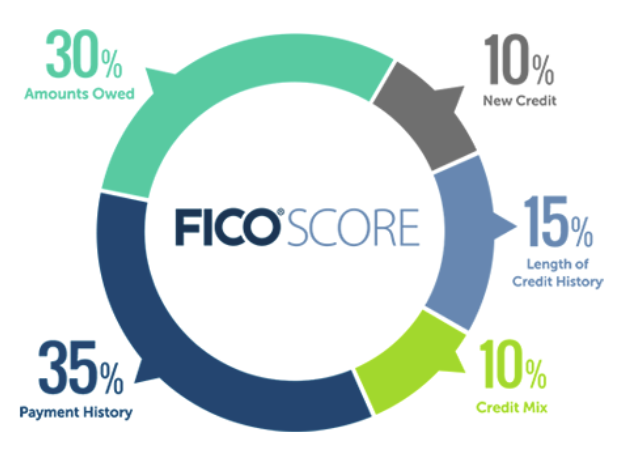

#### Payment History (35%)
- Payment history has the highest weightage as credit report shows how well an applicant is able to meet credit bill dealines. The longer the history, the better it is for an applicant as lenders have more data to review.
- In our data set, we do not have this feature.

#### Amounts Owed (30%)
- This refers to the amount an applicant currently owes. It shows the ratio of money owed and the amount of available credit left. A tell tale sign of a high risk defaulters will have their credit lines fully extended and this lowers credit score.

#### Length of Credit History (15%)
- It is always good to have a long history of credit. It can indicate that an applicant has the responsibility to handle credits. For applicant who has a short history of credit but possess good quality in other aspect, applicant may still qualify for loan.
- Even though credit history stands at only 15%, we can still try to generate a new feature out from our data set.

#### Credit Mix (10%)
- This parameter reflects all different types of credit an applicant has (retail, credit, mortgage, vehicle, etc.) A good mix of credit tends to reflect good credit score.

#### New Credit (10%)
- New credit refers to credit lines that applicants opened recently. When applicants open multiple credit lines within a short span of time. It is an indicator that applicant is a risk borrower and lowers credit score.

Let's first try to explore some plots
1. fig_2c1 to show 'loan_amnt', 'term_months', 'installment', 'loan_status'
2. fig_2c2 to show 'grade', 'sub_grade', 'int_rate', 'loan_status'
3. fig_2c3 to show 'initial_list_status', 'term_months', 'loan_amnt', 'loan_status'
4. fig_2c4 to show 'pub_rec_bankruptcies', 'loan_amnt', 'application_type', 'loan_status'
5. fig_2c5 to show 'purpose', 'open_acc', 'loan_amnt', 'installment', 'loan_status'

### fig_2c1. Scatter Plot between 'loan_amnt', 'term_months', 'installment', 'loan_status'.

In [ ]:
# create a new df
fig_2c1_df = train_df[['loan_amnt', 'term_months', 'installment', 'loan_status']]

# make loan status to object data type for it to become discrete color
fig_2c1_df['loan_status'] = fig_2c1_df['loan_status'].astype(str)

# set the labels to change
label_to_chng = {'installment':"Monthly Installment ($)",
                 'loan_amnt':"Loan Amount ($)",
                 'term_months':"Term (Months) ",
                 'loan_status':'Loan Status'}

# design the scatter plot
fig_2c1 = px.scatter(fig_2c1_df, x="installment", y="loan_amnt",
                     size="loan_amnt", color="loan_status", facet_col="term_months",
                     log_x=True, log_y=True, size_max=40,
                     labels=label_to_chng, height=600,
                     title="Scatter Plot of Monthly Installment and Loan Amount Between Different Repayment Terms",
                     marginal_x="histogram"
                    )

fig_2c1.show()

#### Insights
1. The amount of loan and installment shares a linear relationship. Applicant with higher montly installment would naturally apply for higher loan.
2. For term_months = 60, applicants are showing a trend of applying higher loan only when the installment begins at around \\$80.
3. For term_months = 36, the similar trend begins when installment are around \\$30 to \\$50.
4. The distribution for monthly installment when term_months = 60 is left-skwed while the distribution for monthly installment when term_months = 36 is more widely distributed.
5. Generally, when the loan repaymenmt period is longer, it means applicants have applied a large loan.
6. This dataset has shown that term_months = 36 is more popular than term_months = 60.

### Histogram between 'sub_grade', 'int_rate', 'loan_status'
- In the data set we see that loan applicants are categories in grades and sub grades.
- LendingClub determine each applicant to a sub grade after reviewing their applicant and each sub grade has different interest rate.
- In the [LendingClub website](https://www.lendingclub.com/foliofn/rateDetail.action), each applicant is categories into grade A, B, C, D, E, F & G. Follow by sub grades A1, A2, A3, A4, A5 (same for subsequent grades).
- With the base interest rate as 5.05% for all categories, LendingClub then add on the interest rate with a certain percentage for their safety margin. The more risky an applicant is, the more LendingClub adds on.

In [ ]:
# set the labels to change
label_to_chng = {'sub_grade':"Sub Grade",
                 'loan_status':"Loan Status"}

# design the histogram
fig_2c2 = px.histogram(train_df, x = 'sub_grade', y = 'int_rate',
                       color = 'loan_status', height = 700, histfunc='avg',
                       labels = label_to_chng, category_orders = {"sub_grade":sorted(train_df.sub_grade.unique())},
                       title = 'Average Interest Rate Between Different Sub Grades',
                       barmode="group", orientation="v"
                      )

fig_2c2.show()

#### Insights

- Here, we can see that the average interest rate has a linear relationship with sub grades.
- If you look closely, the average interest rate for applicant falling into category A1 to E5 for applicants who are more likly to not default is a liitle bit higher than applicants who are most likely to default.
- This trend swaps when applicants fall into category F1 to G5.
- These sub grades can be mapped followin to the model rank table as seen in LendingClub website.

### fig_2c3. Histogram between 'initial_list_status', 'grade', 'loan_status'.
- w -> whole loan (1 loan = 1 investor)
- f -> fractional loan (1 loan = a pool of investors)

In [ ]:
# set the labels to change
label_to_chng = {'initial_list_status':"Initial List Status",
                 'loan_status':"Loan Status",
                 'grade':"Grade"}

# design the histogram
fig_2c3 = px.histogram(train_df, y="initial_list_status", color="grade",
                       labels=label_to_chng, category_orders = {"grade":sorted(train_df.grade.unique())},
                       title="Popularity of Whole/Fractional Loans")
fig_2c3.show()

#### Insights

- Fractional loan draw more attention to a larger group of borrowers.
- A possibility can be that fractional loan tends to be more popular for investors as it is more affordable (bite-size).
- Shorter time needed for the loan amount to be fully funded in case borrowers are urgently in need of loan.
- Whole loan will attract only the rich of the riches (small percentage of the market) where not many people can afford.
- That is where we can observe a distinct difference in the histogram.

### fig_2c4 Scatterplot between 'pub_rec_bankruptcies', 'loan_amnt', 'application_type', 'loan_status'

In [ ]:
# create a new df for this plot
fig_2c4_df = train_df[['pub_rec_bankruptcies', 'loan_amnt', 'application_type','loan_status']]

# make loan status to object data type for it to become discrete color
fig_2c4_df['loan_status'] = fig_2c4_df['loan_status'].astype(str)

# set the labels to change
label_to_chng = {'pub_rec_bankruptcies':"Public Record Bankruptcies",
                 'loan_amnt':"Loan Amount",
                 'loan_status':"Loan Status",
                 'application_type':"Loan Application Type"}

# design the scatter plot
fig_2c4 = px.scatter(fig_2c4_df, x='pub_rec_bankruptcies', y='loan_amnt',
                     color='loan_status', facet_col='application_type', marginal_x='histogram',
                     labels=label_to_chng,
                     title='Loan Applications Pattern Based on Bankruptcy Counts',
                     height=600
                    )
fig_2c4.show()

#### Insights

- Direct Pay and Joint type of applications are much less seen once an applicant has a public record of bankruptcy (just by having 1 count).
- The loan amount also decreases as the count of bankruptcy increases.
- In terms of giving this categorical feature an ordinal numeric characteristics, "INDIVIDUAL"=1, "DIRECT_PAY"=2, "JOINT"=3.

### fig_2c5 to show 'purpose', 'open_acc', 'loan_amnt', 'installment', 'loan_status'

In [ ]:
# create a new df for this plot
fig_2c5_df = train_df[['purpose', 'annual_inc', 'loan_amnt', 'installment', 'loan_status']]

# make loan status to object data type for it to become discrete color
fig_2c5_df['loan_status'] = fig_2c5_df['loan_status'].astype(str)

# set the labels to change
label_to_chng = {'annual_inc':"Applicant Annual Income",
                 'installment':"Installment",
                 'loan_status':"Loan Status",
                 'application_type':"Loan Application Type"}

# design the scatter plot
fig_2c5 = px.scatter(fig_2c5_df, x='installment', y='annual_inc',
                     size='loan_amnt', color='loan_status',
                     facet_col='purpose', facet_col_wrap=7,
                     size_max=25, height=600, width=1000,
                     title='Monthly Installment and Applicants\' Annual Income Based on Loan Purpose',
                     log_y=True, labels=label_to_chng
                    )

# rotate facet column annotations
for annotation in fig_2c5['layout']['annotations']:
    annotation['textangle']=-10

# edit facel column annotations
# update units along x axis
fig_2c5.for_each_annotation(lambda a: a.update(text=a.text.split("purpose=")[-1])).update_xaxes(tickangle=45, tickprefix="$")

#### Insights
- Applicants who applied for loans such as debt_consolidation, home_improvement, credit_card, major_purchase generally have high earning power, crossing the \\$1 million dollars mark.
- Monthly installment payment for education are at the low end and not above \\$1K.
- Some noticeable outliers can be seen for loans such as debt_consolidation & credit_card.

### New features possible to create:
1. Model Rank (Following to LC website). https://www.lendingclub.com/foliofn/rateDetail.action
2. Monthly Income (annual_inc / 12)
3. Employment Status (employed=0, unemployed=1), assuming having 1 year or lesser considered unemployed.
4. Length of Credit History. Longer credit history represent more data for lenders to review the credit  history, more likely to approve a loan as compared to applicant without credit history.

# 3.📝Data Preparation (Part 2)

### 3a. change home_ownership data -> "MORTGAGE"=1, "RENT"=2, "OWN"=3, "NONE"=4, "OTHER"=4, "ANY"=4.

In [ ]:
# def ownership_to_num(row):
#     """
#     This function will look into the values within home_ownership columns,
#     it returns 1 (denoting the applicant home ownerhsip is "MORTGAGE"),
#     it returns 2 (denoting the applicant home ownership is "RENT"),
#     it returns 3 (denoting the applicant home ownerhsip is "OWN"),
#     it returns 4 (denoting the applicant home ownership is "NONE", "OTHER" or "ANY")
#     """
#     # when an applicant home ownerhsip is "MORTGAGE"
#     if row['home_ownership'] == "MORTGAGE":
#         return 1
    
#     # when an applicant home ownerhsip is "RENT"
#     if row['home_ownership'] == "RENT":
#         return 2
    
#     # when an applicant home ownerhsip is "OWN"
#     if row['home_ownership'] == "OWN":
#         return 3
    
#     # when an applicant home ownerhsip is "NONE", "OTHER" or "ANY"
#     else:
#         return 4

In [ ]:
def ownership_to_num(ownership):
    
    ownership_dict = {"MORTGAGE" : 1,
                      "RENT" : 2,
                      "OWN" : 3,
                      "NONE" : 4,
                      "OTHER" : 4,
                      "ANY" : 4}
    
    try:
        return ownership_dict[ownership]
    
    except KeyError:
        return None

In [ ]:
# Next we apply the train_df
train_df['home_ownership'] = train_df['home_ownership'].apply(ownership_to_num)

# Next we apply the test_df
test_df['home_ownership'] = test_df['home_ownership'].apply(ownership_to_num)

### 3b. change initial_list_status -> "w"=0, "f"=1.

In [ ]:
def initList_status_to_num(status):
    
    stats_dict = {"f" : 1,
                  "w" : 0
                 }
    
    try:
        return stats_dict[status]
    
    except KeyError:
        return None

In [ ]:
# Next we apply the train_df
train_df['initial_list_status'] = train_df['initial_list_status'].apply(initList_status_to_num)

# Next we apply the test_df
test_df['initial_list_status'] = test_df['initial_list_status'].apply(initList_status_to_num)

### 3c. change application_type -> "INDIVIDUAL"=1, "DIRECT_PAY"=2, "JOINT"=3.

In [ ]:
def app_type_to_num(type_name):
    
    app_dict = {"INDIVIDUAL" : 1,
                "DIRECT_PAY" : 2,
                "JOINT": 3
               }
    
    try:
        return app_dict[type_name]
    
    except KeyError:
        return None

In [ ]:
# Next we apply the train_df
train_df['application_type'] = train_df['application_type'].apply(app_type_to_num)

# Next we apply the test_df
test_df['application_type'] = test_df['application_type'].apply(app_type_to_num)

# 4.🔄 Feature Engineering
---

> **OVERALL GOAL:** 
> - Select relevant features and enhance them to improve the overall performance of the machine learning model

First we convert the text data into useful categorical numerical variable

In [ ]:
# Perform your Feature Enginerring in the following cells. You may create as many cells as you need

## 4a. Create new feature -> model_rank
- From section 2c fig_2c1, we have mentioned that on the [LendingClub website](https://www.lendingclub.com/foliofn/rateDetail.action), each applicant is categories into grade A, B, C, D, E, F & G. Follow by sub grades A1, A2, A3, A4, A5 (same for subsequent grades).
- Here we know that the sub grades are ordinal, so we use can sklearn LabelEncoder function to new a new column called model_rank. Smart of sklearn to know that A1 comes first, follow by A2, then A3...etc.
- However, after the .transform method, the LabelEncoder funtion assigned value 0 to A1 (which is rank 1). In this case, we +1 to each of the encoded value in model_rank to obtain the correct rank order.

In [ ]:
# create the label encoder function for model_rank column
label_encoder_mRank = LabelEncoder()

# apply the label encoder function
label_encoder_mRank.fit(train_df['sub_grade'])

# create a new column to input the encoded values
train_df['model_rank'] = label_encoder_mRank.transform(train_df['sub_grade'])

# add 1 to each value as sklearn label encoder function uses 0 for rank 1
# LendingClub model rank uses 1 for rank 1
train_df['model_rank'] = train_df.model_rank + 1

In [ ]:
# do the same for test_df
# using the same label encoder function for train set
# create a new column to input the encoded values
test_df['model_rank'] = label_encoder_mRank.transform(test_df['sub_grade'])

# add 1 to each value as sklearn label encoder function uses 0 for rank 1
# LendingClub model rank uses 1 for rank 1
test_df['model_rank'] = test_df.model_rank + 1

## 4b. Create new feature -> month_inc
- Monthly income is actually one of the important detail to look at while lenders review a loan application.
- If possible, monthly income can be useful in calculating factors which lenders use them to determine high risk borrowers apart from low risk.
- This new column can be create using annual_inc.

In [ ]:
# create new column called monthly_inc in train data set
train_df['monthly_inc'] = (train_df['annual_inc'] / 12).round()

# create new column called monthly_inc in test data set
test_df['monthly_inc'] = (test_df['annual_inc'] / 12).round()

## 4c. Create new feature -> emp_status
- Even though there are features such employement title, years and income details in train and test dataset, we will try to create a new feature to represent the employment status of an applicant. 
- By doing so, when creating this new column, we hope it can give both data sets a categorical sense (in numeric form) that if an applicant is employed or not.
- The data description denotes that when emp_length_years = 0, it means the applicant has less than one year of employment, and 10 means ten or more years.
- To simplify things, if emp_length_years = 0, the loan applicant shall be noted as unemployed.
- When an applicant is unemployed, its value in emp_status = 1.
- When an applicant is employed, its value in emp_status =0.

In [ ]:
def create_emp_status(row):
    """
    This function will look into the values within emp_length_years and if the value is 0,
    it returns 1 (denoting the applicant is unemployed).
    When the value is 1 and above, the fucntion will return 0 (denoting the applicant is employed).
    """

    # when an applicant is unemployed, its value in emp_status = 1.
    if row['emp_length_years'] == 0:
        return 1
    
    # when an applicant is employed, its value in emp_status =0.
    else:
        return 0

# create a new column called emp_status and apply the function to train_df
train_df['emp_status'] = train_df.apply(lambda row: create_emp_status(row), axis=1)

In [ ]:
# repeat same step for test_df
# create a new column called emp_status and apply the function to test_df
test_df['emp_status'] = test_df.apply(lambda row: create_emp_status(row), axis=1)

## 4d. Create new feature -> years_credit_history
- As mentioned above, lenders will take into consideration the length of credit history of loan applicants.
- This is because when the longer the credit history is, the more credit transaction there are for lenders to review any late payments, past credit usage and any activities which reflect risky borrorwers' behavoirs.
- To create this new feature, we will make use of earliest_cr_line and issue_d.
- We find the difference in years since the year the borrower's earliest reported credit line was opened and the period where the loan was funded.
- Before we can do that, we have to create some more new columns by extracting the year value from earliest_cr_line.

In [ ]:
# create a new column called years_credit_history in train_df
# subtract the date from issue_d to earliest_cr_line, but return value in years (rounded).
train_df['years_credit_history'] = ((train_df['issue_d'] - train_df['earliest_cr_line'])/np.timedelta64(1, 'Y')).round()

In [ ]:
# create a new column called years_credit_history in test_df
# subtract the date from issue_d to earliest_cr_line, but return value in years (rounded).
test_df['years_credit_history'] = ((test_df['issue_d'] - test_df['earliest_cr_line'])/np.timedelta64(1, 'Y')).round()

## 4e. Create new feature -> year_earliest_cr_line & month_earliest_cr_line
- Create new year and month column for earliest_cr_line.

In [ ]:
# extract year from earliest_cr_line under train_df
train_df['year_earliest_cr_line'] = train_df['earliest_cr_line'].dt.year

# extract month from earliest_cr_line under train_df
train_df['month_earliest_cr_line'] = train_df['earliest_cr_line'].dt.month

In [ ]:
train_df[['earliest_cr_line','year_earliest_cr_line','month_earliest_cr_line']]

In [ ]:
# extract year from earliest_cr_line under test_df
test_df['year_earliest_cr_line'] = test_df['earliest_cr_line'].dt.year

# extract month from earliest_cr_line under test_df
test_df['month_earliest_cr_line'] = test_df['earliest_cr_line'].dt.month

## 4f. Create new feature -> year_issue_d & month_issue_d
- Create new year and month column for issue_d.

In [ ]:
# extract year from issue_d under train_df
train_df['year_issue_d'] = train_df['issue_d'].dt.year

# extract month from earliest_cr_line under train_df
train_df['month_issue_d'] = train_df['issue_d'].dt.month

In [ ]:
# extract year from issue_d under test_df
test_df['year_issue_d'] = test_df['issue_d'].dt.year

# extract month from earliest_cr_line under test_df
test_df['month_issue_d'] = test_df['issue_d'].dt.month

In [ ]:
# back up
# train_df.to_csv('training_df.csv', header=True)
# test_df.to_csv('testing_df.csv', header=True)

## 4g. One-Hot Encoding & Feature Scaling
Before we start off with this section, we should note that K-Nearest Neigbour, RandomForest and CatBoost are some of the selected machine learning model which we want to implement in this project.<br>


<b>K-Nearest Neighbors</b>
1. Feature Scaling: Distance-based model will require feature scaling
2. One-Hot Encoding: Distance-based model works well with numeric features.<br>

<b>RandomForest</b>
1. [Feature Scaling](https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package#:~:text=Random%20Forest%20is%20a%20tree,result%20would%20be%20the%20same.): Not required. Scaling will not affect partitioning, not affected by features dimensions differences.
2. [One-Hot Encoding](https://stackoverflow.com/questions/65722374/one-hot-encoding-in-random-forest-classifier): Not Required. 0s and 1s will result the trees to grow in a single direction (sparse decision tree).<br>

<b>CatBoost</b><br>
[CatBoost algorithm](https://github.com/catboost/catboost) is based on gradient boosting over decision tree.
1. Feature Scaling: Not required.
2. One-Hot Encoding: Not required.<br>


To proceed with this section, we will have to make several copies of train_df due to different requirement from each machine learning model.

In [ ]:
# need scaling and One-Hot
knn_train_df = train_df.copy(deep=True)

# no need scaling and One-Hot
catB_train_df = train_df.copy(deep=True)

# no need scaling and One-Hot
RF_train_df = train_df.copy(deep=True)

# 5.🤖 Models Building and Comparing Model Perforamance
---

> **OVERALL GOAL:** 
> - Building a machine learning model that is capable of generating predictions

<b> Evaluate your model (using only lc_trainingset.csv)</b><br>
We generate a randomforest model by fitting the training data using <code>.fit()</code>, and thereafter generate predictions using <code>.predict()</code>

<b>We evalute the model's accuracy using <code>metrics.accuracy_score()</code></b>

## 5a. Logistic Regression (baseline model)

Here we start off by creating a baseline model which you can use to compare against

#### Select the optimal features, prepare the data, instantiate the LogisticsRegression model and perform training and prediction | kfold
- GridSearchCV applied for hyperparameter tuning

In [ ]:
# Select the features to use to predict the loan_status
features = train_df[['loan_amnt', 'term_months', 'int_rate','installment','emp_length_years',
                     'home_ownership','initial_list_status','application_type','state', 'model_rank',
                     'monthly_inc','year_earliest_cr_line','year_issue_d',]]

# assign selected features to X
X = features

# assign the outcome
y = train_df['loan_status']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# create the logistic regression object
log_reg = LogisticRegression(random_state=123)

# define the parameters
parameters = {"penalty": ['l2', 'none'],
              "C" : [1, 0.1, 0.001],
              "max_iter": [180, 190, 200]}

# create the tuned RF model
log_reg_grid = GridSearchCV(estimator=log_reg, param_grid=parameters, verbose=3)

# fit the model
log_reg_grid.fit(X_train, y_train)

# show the best parameters for the tuned logistic regression model
print(log_reg_grid.best_params_)

# generate predictions
log_reg_y_pred_tts = log_reg_grid.predict(X_test)

# Accuracy Score on test dataset
log_reg_acc_test_tts = metrics.accuracy_score(y_test, log_reg_y_pred_tts)
print()
print('Logistic Regression Accuracy (train_test_split): ', log_reg_acc_test_tts*100, '%')

# AUC on test dataset
log_reg_AUC_tts = metrics.roc_auc_score(y_test, log_reg_y_pred_tts)
print('Logistic Regression AUC (train_test_split): ', log_reg_AUC_tts)

#### Select the optimal features, prepare the data, instantiate the LogisticsRegression model and perform training and prediction | kfold
- GridSearchCV applied for hyperparameter tuning

In [ ]:
# Select the features to use to predict the loan_status
features = train_df[['loan_amnt', 'term_months', 'int_rate','installment','emp_length_years',
                     'home_ownership','initial_list_status','application_type','state', 'model_rank',
                     'monthly_inc','year_earliest_cr_line','year_issue_d',]]

# assign selected features to X
X = features

# assign the outcome
y = train_df['loan_status']

# Split the data into 10 set
kf = KFold(n_splits=10)

# create the logistic regression object
log_reg = LogisticRegression(random_state=123)

# define the parameters
parameters = {"penalty": ['l2', 'none'],
              "C" : [1, 0.1, 0.001],
              "max_iter": [180, 190, 200]}

# create the tuned RF model
log_reg_grid = GridSearchCV(estimator=log_reg, param_grid=parameters, verbose=3)

# List of accuracy for each fold
k_fold_accuracy = []

## Iterate through each fold and calculate the RMSE for each fold
for train_index, test_index in kf.split(X):
    
    # Extract the training and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit model
    log_reg_model = log_reg_grid.fit(X_train, y_train)
    log_reg_y_pred_kf = log_reg_model.predict(X_test)
    
    #Calculate Accuracy for the fold and append it
    accuracy_kf = metrics.accuracy_score(y_test, log_reg_y_pred_kf)
    k_fold_accuracy.append(accuracy_kf)

# show the best parameters for the tuned logistic regression model
print(log_reg_grid.best_params_)
    
print('Logistic Regression Accuracy per Fold:', k_fold_accuracy)
print('Logistic Regression Avg Accuracy (KFold):', statistics.mean(k_fold_accuracy)*100, '%')
print('Logistic Regression AUC (KFold):', metrics.roc_auc_score(y_test, log_reg_y_pred_kf)) 

## 5b. Random Forest Classifer

#### Select the optimal features, prepare the data, instantiate the RandomForestClassifier model and perform training and prediction | train_test_split
- GridSearchCV applied for hyperparameter tuning

In [ ]:
# Select the features to use to predict the loan_status
features = RF_train_df[['loan_amnt', 'term_months', 'int_rate', 'installment', 'emp_length_years',
                        'home_ownership', 'annual_inc', 'dti', 'open_acc', 'pub_rec',
                        'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type',
                        'mort_acc', 'pub_rec_bankruptcies', 'state', 'model_rank', 'monthly_inc',
                        'emp_status', 'years_credit_history', 'year_earliest_cr_line', 'month_earliest_cr_line', 'year_issue_d',
                        'month_issue_d']]

# Assign selected features to X
X = features

# Assign the outcome to y
y = RF_train_df['loan_status']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Create the base RandomForestClassifer model
RF_clf = RandomForestClassifier(random_state=123)

# define the parameters
parameters = {"max_depth": [15,20,25],
              "min_samples_split" : [2,3,4],
              "min_samples_leaf" : [2,3,4]}

# create the tuned RF model
RF_grid = GridSearchCV(estimator=RF_clf, param_grid=parameters, verbose=3)

# fit the tuned model
RF_grid.fit(X_train, y_train)

# show to best parameters for the tuned RF model
print(RF_grid.best_params_)

In [ ]:
# make predictions with the tuned RF model
RF_grid_model_y_pred_tts = RF_grid.predict(X_test)

# Accuracy Score on test dataset
print('Random Forest Accuracy (train_test_split):', metrics.accuracy_score(y_test, RF_grid_model_y_pred_tts) * 100, '%')

# AUC on test dataset
print('Random Forest AUC (train_test_split):', metrics.roc_auc_score(y_test, RF_grid_model_y_pred_tts))

#### Select the optimal features, prepare the data, instantiate the RandomForestClassifier model and perform training and prediction | KFold
- GridSearchCV applied for hyperparameter tuning

In [ ]:
# Select the features to use to predict the loan_status
features = RF_train_df[['loan_amnt', 'term_months', 'int_rate', 'installment', 'emp_length_years',
                        'home_ownership', 'annual_inc', 'dti', 'open_acc', 'pub_rec',
                        'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type',
                        'mort_acc', 'pub_rec_bankruptcies', 'state', 'model_rank', 'monthly_inc',
                        'emp_status', 'years_credit_history', 'year_earliest_cr_line', 'month_earliest_cr_line', 'year_issue_d',
                        'month_issue_d']]

# Assign selected features to X
X = features

# Assign the outcome to y
y = RF_train_df['loan_status']

# Split the data into 10 set
kf = KFold(n_splits=10)

# Create the base RandomForestClassifer model
RF_clf = RandomForestClassifier(random_state=123)

# define the parameters
parameters = {"max_depth": [15,20,25],
              "min_samples_split" : [2,3,4],
              "min_samples_leaf" : [2,3,4]}

# create the tuned RF model
RF_grid = GridSearchCV(estimator=RF_clf, param_grid=parameters, verbose=3)

# List of accuracy for each fold
RF_k_fold_accuracy = []

## Iterate through each fold and calculate the RMSE for each fold
for train_index, test_index in kf.split(X):
    
    # Extract the training and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit model
    RF_model = RF_grid.fit(X_train, y_train)
    RF_model_y_pred_kf = RF_model.predict(X_test)
    
    #Calculate Accuracy for the fold and append it
    accuracy_RF_grid_kf = metrics.accuracy_score(y_test, RF_model_y_pred_kf)
    RF_k_fold_accuracy.append(accuracy_RF_grid_kf)

# show the best parameters for the tuned logistic regression model
print(RF_grid.best_params_)
    
print('Random Forest Accuracy per Fold:', RF_k_fold_accuracy)
print('Random Forest Avg Accuracy (KFold):', statistics.mean(RF_k_fold_accuracy)*100, '%')
print('Random Forest AUC (KFold):', metrics.roc_auc_score(y_test, RF_model_y_pred_kf)) 

## 5c. K-Nearest Neighbour

#### start off by scaling the features

In [ ]:
# identify the columns to scale
num_dtype = ['int64','float64']
num_df = knn_train_df.select_dtypes(include=num_dtype).columns

# drop the outcome because we do not want to scale it
num_df = num_df.drop('loan_status')
num_df

In [ ]:
# create the scaling object
sc_X = StandardScaler()

# pass the train_df with numeric columns through the scaler
knn_train_df[num_df] = sc_X.fit_transform(knn_train_df[num_df])

#### Select the scaled features, prepare the data, instantiate the KNeighborsClassifier model and perform training and prediction | train_test_split
- GridSearchCV applied for hyperparameter tuning

In [ ]:
# Select the features to use to predict the loan_status
features = num_df

# Assign selected features to X
X = knn_train_df[features]

# Assign the outcome to y
y = knn_train_df['loan_status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

# create the K-Nearest Neighbor classifier object
knn_clf = KNeighborsClassifier()

# define the parameters
parameters = {"n_neighbors": [18,20,22],
              "weights" : ['uniform', 'distance'],
              "p" : [1,2,],
              "metric" : ['minkowski', 'chebyshev']}

# create the tuned knn model
knn_grid = GridSearchCV(estimator=knn_clf, param_grid=parameters, verbose=3)

    
# fit the model
knn_grid_tts = knn_grid.fit(X_train, y_train)
    
# make predictions
knn_grid_y_pred_tts = knn_grid_tts.predict(X_test)
    
# Accuracy Score on test dataset
print('K-Nearest Neighbors Accuracy (train_test_split):', metrics.accuracy_score(y_test, knn_grid_y_pred_tts) * 100, '%')

# AUC on test dataset
print('Random Forest AUC (train_test_split):', metrics.roc_auc_score(y_test, knn_grid_y_pred_tts))

#### Select the scaled features, prepare the data, instantiate the KNeighborsClassifier model and perform training and prediction | KFold
- GridSearchCV applied for hyperparameter tuning

In [ ]:
# Select the features to use to predict the loan_status
features = num_df

# Assign selected features to X
X = knn_train_df[features]

# Assign the outcome to y
y = knn_train_df['loan_status']

# Split the data into ten set
kf = KFold(n_splits=10)

# create the K-Nearest Neighbor classifier object
knn_clf = KNeighborsClassifier()

# define the parameters
parameters = {"n_neighbors": [18,20,22],
              "weights" : ['uniform', 'distance'],
              "p" : [1,2,],
              "metric" : ['minkowski', 'chebyshev']}

# create the tuned knn model
knn_grid = GridSearchCV(estimator=knn_clf, param_grid=parameters, verbose=3)

# List of RMSE for each fold
knn_k_fold_Accuracy = []

# Iterate through each fold and calculate the RMSE for each fold
for train_index, test_index in kf.split(X):
    
    # Extract the training and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit model
    knn_grid_kf = knn_grid.fit(X_train, y_train)
    knn_grid_y_pred_kf = knn_grid_kf.predict(X_test)
    
    #Calculate RMSE for the fold and append it
    knn_grid_accuracy_kf = metrics.accuracy_score(y_test, knn_grid_y_pred_kf)
    knn_k_fold_Accuracy.append(knn_grid_accuracy_kf)
    
# show the best parameters for the tuned logistic regression model
print(knn_grid.best_params_)
    
print('K-Nearest Neighbors Accuracy per Fold:', knn_k_fold_Accuracy)
print('K-Nearest Neighbors Avg Accuracy (KFold):', statistics.mean(knn_k_fold_Accuracy)*100, '%')
print('K-Nearest Neighbors AUC (KFold):', metrics.roc_auc_score(y_test, knn_grid_y_pred_kf)) 

## 5d. Cat Boost Classifier

#### Select the optimal features, prepare the data, instantiate the CatBoostClassifier model and perform training and prediction | train_test_split
- GridSearchCV applied for hyperparameter tuning

In [ ]:
# Assign selected features to X
X = catB_train_df[['loan_amnt', 'term_months', 'int_rate', 'installment', 'grade',
              'sub_grade', 'emp_title', 'emp_length_years', 'home_ownership','annual_inc',
              'verification_status', 'purpose', 'title', 'open_acc',
              'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
              'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address', 'state',
              'model_rank', 'monthly_inc', 'emp_status', 'years_credit_history', 'year_earliest_cr_line',
              'month_earliest_cr_line', 'year_issue_d', 'month_issue_d']]
# Assign the outcome to y
y = catB_train_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

In [ ]:
# Instantiate the model object
catB_clf = CatBoostClassifier(random_seed=5)

# define the parameters
parameters = {'learning_rate': [0.01, 0.05, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

# create the tuned knn model
catB_grid = GridSearchCV(estimator=catB_clf, param_grid=parameters, verbose=3)

# Fit the model with the training data
catB_grid_tts = catB_grid.fit(X_train, y_train, cat_features=[4,5,6,10,11,12,22,23])

# Predict the target on the test dataset
catB_grid_y_pred_tts = catB_grid_tts.predict(X_test)
    
# Accuracy Score on test dataset
print('CatBoost Classifier Accuracy (train_test_split):', metrics.accuracy_score(y_test, catB_grid_y_pred_tts) * 100, '%')

# AUC on test dataset
print('CatBoost Classfier AUC (train_test_split):', metrics.roc_auc_score(y_test, catB_grid_y_pred_tts))

#### Select the optimal features, prepare the data, instantiate the CatBoostClassifier model and perform training and prediction | kfold
- GridSearchCV applied for hyperparameter tuning

In [ ]:
# Assign selected features to X
X = catB_train_df[['loan_amnt', 'term_months', 'int_rate', 'installment', 'grade',
              'sub_grade', 'emp_title', 'emp_length_years', 'home_ownership','annual_inc',
              'verification_status', 'purpose', 'title', 'open_acc',
              'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
              'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address', 'state',
              'model_rank', 'monthly_inc', 'emp_status', 'years_credit_history', 'year_earliest_cr_line',
              'month_earliest_cr_line', 'year_issue_d', 'month_issue_d']]

# to see index of X
X.info()

In [ ]:
# Assign selected features to X
X = catB_train_df[['loan_amnt', 'term_months', 'int_rate', 'installment', 'grade',
              'sub_grade', 'emp_title', 'emp_length_years', 'home_ownership','annual_inc',
              'verification_status', 'purpose', 'title', 'open_acc',
              'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
              'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address', 'state',
              'model_rank', 'monthly_inc', 'emp_status', 'years_credit_history', 'year_earliest_cr_line',
              'month_earliest_cr_line', 'year_issue_d', 'month_issue_d']]

# Assign the outcome to y
y = catB_train_df['loan_status']

# Instantiate the model object
catB_clf = CatBoostClassifier(random_seed=5)

# define the parameters
parameters = {'learning_rate': [0.01, 0.05, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

# create the tuned knn model
catB_grid = GridSearchCV(estimator=catB_clf, param_grid=parameters, verbose=3)

# Split the data into ten set
kf = KFold(n_splits=10)

# List of RMSE for each fold
catB_k_fold_Accuracy = []

# Iterate through each fold and calculate the RMSE for each fold
for train_index, test_index in kf.split(X):
    
    # Extract the training and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit model
    catB_grid_kf = catB_grid.fit(X_train, y_train, cat_features=[4,5,6,10,11,12,22,23])
    catB_grid_y_pred_kf = catB_grid_kf.predict(X_test)
    
    #Calculate RMSE for the fold and append it
    catB_grid_accuracy_kf = metrics.accuracy_score(y_test, catB_grid_y_pred_kf)
    catB_k_fold_Accuracy.append(catB_grid_accuracy_kf)
    
# show the best parameters for the tuned catboost classifier model
print(knn_grid.best_params_)

print('CatBoost Classifier Accuracy per Fold:', catB_k_fold_Accuracy)
print('CatBoost Classifier Avg Accuracy (KFold):', statistics.mean(catB_k_fold_Accuracy)*100, '%')
print('CatBoost Classifier AUC (KFold):', metrics.roc_auc_score(y_test, catB_grid_y_pred_kf)) 

## 5e. Which is the highest scoring model?

# 6.📊 Generate and Export Predictions from your Final Model
---

> **OVERALL GOAL:** 
> - Export your predictions and submit it to kaggle

## 6a. Re-fit your final model on train.csv

Say for instance you have determined the (based on accuracy)
1. optimal basket of features, 
2. the most optimal model for this dataset, and 
3. the best parameters for the model you have chosen

You should then retrain the chosen model with the optimal parameters, on the chosen basket of features on all the 316824 rows of data you have (instead of just on X_train, y_train). This is because you want to fully utilise your 316824 rows of data to maximise what your model can learn!

In [ ]:
X = catB_train_df[['loan_amnt', 'term_months', 'int_rate', 'installment', 'grade',
              'sub_grade', 'emp_title', 'emp_length_years', 'home_ownership','annual_inc',
              'verification_status', 'purpose', 'title', 'open_acc',
              'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
              'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address', 'state',
              'model_rank', 'monthly_inc', 'emp_status', 'years_credit_history', 'year_earliest_cr_line',
              'month_earliest_cr_line', 'year_issue_d', 'month_issue_d']]

# Select the features you want to use to predict the loan_status
y = catB_train_df['loan_status']

print(len(X))
print(len(y))

catB_clf = CatBoostClassifier(random_seed=5)

# define the parameters
parameters = {'learning_rate': [0.01, 0.05, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

# create the tuned knn model
catB_grid = GridSearchCV(estimator=catB_clf, param_grid=parameters, verbose=3)

# fit the tuned model
catB_model = catB_grid.fit(X, y, cat_features=[4,5,6,10,11,12,22,23])

In [ ]:
#Extract the same features from the test set
kaggle_x = test_df[['loan_amnt', 'term_months', 'int_rate', 'installment', 'grade',
              'sub_grade', 'emp_title', 'emp_length_years', 'home_ownership','annual_inc',
              'verification_status', 'purpose', 'title', 'open_acc',
              'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
              'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address', 'state',
              'model_rank', 'monthly_inc', 'emp_status', 'years_credit_history', 'year_earliest_cr_line',
              'month_earliest_cr_line', 'year_issue_d', 'month_issue_d']]

# Predict the target on the test dataset
catB_grid_y_pred_final = catB_grid_tts.predict(kaggle_x)

# Accuracy Score on test set
print('CatBoost Accuracy (Final):', metrics.accuracy_score(y, catB_grid_y_pred_final) * 100, '%')

# AUC on test set
print('CatBoost AUC (Final):', metrics.roc_auc_score(y, catB_grid_y_pred_final))

## 6b. Generate predictions for the test_df

Here, we will generate the predictions for the test_df. Make sure to apply whatever feature engineering technique you performed on train_df to test_df as well.

Here we use <code>.predict_proba</code> instead of <code>.predict()</code> because this is the format which the Kaggle platform requires

In [ ]:
# #Extract the same features from the test set
# kaggle_x = test_df[['loan_amnt', 'term_months', 'int_rate', 'installment', 'grade',
#               'sub_grade', 'emp_title', 'emp_length_years', 'home_ownership','annual_inc',
#               'verification_status', 'purpose', 'title', 'open_acc',
#               'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
#               'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address', 'state',
#               'model_rank', 'monthly_inc', 'emp_status', 'years_credit_history', 'year_earliest_cr_line',
#               'month_earliest_cr_line', 'year_issue_d', 'month_issue_d']]

# probabilities = catB_model.predict_proba(kaggle_x)
# probabilities

In [ ]:
# # extract values from the rightmost column
# kaggle_preds = probabilities[:,1]
# len(kaggle_preds)

Make use of the <code>.to_csv()</code> function to output your predictions in the form of a csv, which will be the format you will be required to submit to Kaggle.

In [ ]:
# output_dataframe = pd.DataFrame({
#     'Id': list(range(len(kaggle_preds))),
#     'Predicted': kaggle_preds
# })
# output_dataframe.to_csv('my_predictions.csv', index=False)  

# # Check for the .csv in the same folder as your Jupyter Notebook
# # Try uploading this .csv to the Kaggle competition!

<div class="alert alert-block alert-warning">
<b>All the Best! May the best model win!</b>
</div>